# Autoencoder Multivariate Training (Expiriment 3)

 Vinayak Sharma
  
 This notebook aims to train an autoencoder on univariate timeseries data from EKS Performance metrics for MANY NODES. The training data is 'non-anomalous'. 

 The model and implementation techniques can be found in the following github: https://github.com/emerelte/kad
 
 The research paper that this work is based on can be found here: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9925210

------

In [34]:
##global variable
timesteps = 20
time_steps = 20
batch_size = 36
n_samples = batch_size*10
features = ['node_cpu_utilization','node_memory_utilization','node_network_total_bytes']

## Imports

In [35]:
# # !pip install -r /root/eks-ml-pipeline/modeling/kad/kad/requirements.txt
# !pip install keras
# !pip install tensorflow

In [36]:
# !pip install tensorflow
# !pip install keras

In [37]:
import logging
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [38]:
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import json
import sys
import statsmodels.api as sm
import os
import keras
from keras import layers, Sequential
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from autoencoder_model_dish_5g import autoencoder_model_dish_5g

from sklearn.model_selection import train_test_split

import _pickle as cPickle


In [39]:
import logging
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [40]:
pd.set_option('display.max_rows', None)

First lets read in our training sample set 

In [41]:
##isolate the first days worth of data
training_df_full = pd.read_parquet('/root/healthy_clusters_node_month.parquet')


In [42]:
training_df_full.shape

(2636965, 19)

In [43]:
columns_to_keep = ['Timestamp','InstanceId','node_cpu_utilization','node_memory_utilization','node_network_total_bytes']

In [44]:
training_df = training_df_full.drop(training_df_full.columns.difference(columns_to_keep),1, inplace=False)
training_df['Timestamp'] = pd.to_datetime(training_df['Timestamp'], unit='ms')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [45]:
len(training_df)

2636965

In [46]:
training_df = training_df.dropna()

In [47]:
test_df = training_df.copy()
training_df = training_df[training_df.InstanceId != 'i-0b36e8825c482f762']

-----

# TRAIN DATASET: Build out Dataset for training on many nodes

now we are starting to build out a training dataset for two nodes. This will prove our understanding of how to model can generalize across many EC2 instances. 

In [48]:
## for normalization
# scaler = StandardScaler()

scaler = StandardScaler()

In [49]:
instance_dfs =[]
for instance in training_df['InstanceId'].unique():
    if(len(training_df[training_df.InstanceId == instance]) >60):
        instance_dfs.append(training_df[training_df.InstanceId == instance].sort_values(by='Timestamp')\
                            .reset_index(drop=True))

In [50]:

import random 

x_train = np.zeros((n_samples,time_steps,len(features)))
for b in range(n_samples):
    
    ##pick random df, and normalize
    df = random.choice(instance_dfs)
    df = df.drop(columns = ['InstanceId'])
    df = df.set_index('Timestamp')
    df = df.sort_index()
    df[features] = scaler.fit_transform(df[features])
    
    
    
    sample = np.zeros((n_samples,len(features)))
    ##make sure length of df is atleast 40
    first_time = random.choice(range(len(df)-time_steps))
    df.head()
    sample = df[features].iloc[first_time:first_time+time_steps]
    x_train[b] = sample

x_train.shape

(360, 20, 3)

our xtrain shape has the following properties: (sample size, time steps, numFeatures)

-------

----

# Model Time

----

### First we train

In [51]:

##actually define the nueral network here. 
##Its a Keras sequential with an LSTM, a dropout, a repeat vector, then another LSTM, another dropout, and a timedistributed output. 
##The output is mapped back the number of features. 
##RepeatVector "Repeats the input n times."https://keras.io/api/layers/reshaping_layers/repeat_vector/

##none of the nueral network is hard coded (except for the number of nuerons b)
model = Sequential(
    [
        layers.Bidirectional(layers.LSTM(128),input_shape=(x_train.shape[1], x_train.shape[2])),
        layers.Dropout(rate = .1),
        layers.RepeatVector(x_train.shape[1]),
        layers.Bidirectional(layers.LSTM(128,return_sequences=True)),
        layers.Dropout(rate = .1),
        layers.TimeDistributed(layers.Dense(x_train.shape[2])),
    ]
)

##nn compile groups layers into a model; the loss here is MAE, optimizer is Adam, learning rate is predefined
model.compile(optimizer=tf.keras.optimizers.Adam(lr=.001), loss="mae")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 256)              135168    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 20, 256)          0         
 or)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 20, 256)          394240    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 20, 256)           0         
                                                      

In [27]:
# model: i_model.IModel = autoencoder_model.AutoEncoderModel(batch_size = batch_size, time_steps = time_steps)

In [28]:
# x_train

In [29]:
history = model.fit(
    x_train,
    x_train,
    epochs=250,
    batch_size=36,
    validation_split=.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)
            


# history = model.fit(x_train,
#                     x_train,
#                     epochs=250,
#                     validation_split=.1,)


Epoch 1/250
9/9 [==============================] - 7s 238ms/step - loss: 0.3310 - val_loss: 0.2296
Epoch 2/250
9/9 [==============================] - 1s 85ms/step - loss: 0.2515 - val_loss: 0.2147
Epoch 3/250
9/9 [==============================] - 1s 84ms/step - loss: 0.2286 - val_loss: 0.2030
Epoch 4/250
9/9 [==============================] - 1s 83ms/step - loss: 0.2219 - val_loss: 0.1959
Epoch 5/250
9/9 [==============================] - 1s 82ms/step - loss: 0.2175 - val_loss: 0.1930
Epoch 6/250
9/9 [==============================] - 1s 82ms/step - loss: 0.2144 - val_loss: 0.1913
Epoch 7/250
9/9 [==============================] - 1s 83ms/step - loss: 0.2117 - val_loss: 0.1887
Epoch 8/250
9/9 [==============================] - 1s 85ms/step - loss: 0.2106 - val_loss: 0.1870
Epoch 9/250
9/9 [==============================] - 1s 83ms/step - loss: 0.2104 - val_loss: 0.1850
Epoch 10/250
9/9 [==============================] - 1s 83ms/step - loss: 0.2095 - val_loss: 0.1857
Epoch 11/250
9/9 [

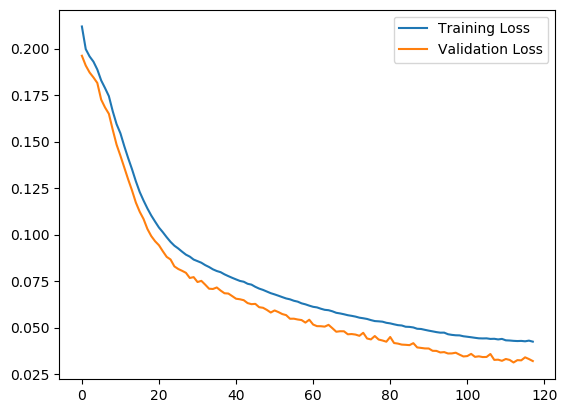

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

###  Bidirectional LSTM 128 Units {per encoder and decoder}
### 1 month of data, tensor size: [36k,40ts,3f]

Now dewa wants all of the residuals

In [108]:
resids = model.predict(x_train)

1125/1125 [==============================] - 28s 24ms/step


In [112]:
np.save('resids', resids)